# Load Libraries

In [1]:
import os
import random
from PIL import Image
import cv2
import tifffile as tiff
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Dropout, UpSampling2D, concatenate
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, BinaryIoU
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

os.environ['SM_FRAMEWORK'] = 'tf.keras'
from segmentation_models import Unet


d:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Segmentation Models: using `tf.keras` framework.


# Read and Prepare Data

In [2]:
dataset_path = '../satalite data/data'
dataset_dir = os.listdir(dataset_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['images', 'labels'] directories.


In [3]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

In [4]:
mask_dir = dataset_path + '/labels'

# Exclude file containing '_' in their name
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Data Preprocessing

> Apply Normalization

In [5]:
def preprocess_global(dataset):
    num_bands = dataset[0].shape[-1]
    global_mins = np.full(num_bands, np.inf)
    global_maxs = np.full(num_bands, -np.inf)
    
    for img in dataset:
        for b in range(num_bands):
            global_mins[b] = min(global_mins[b], np.min(img[:, :, b]))
            global_maxs[b] = max(global_maxs[b], np.max(img[:, :, b]))

    band_stats = pd.DataFrame({
        'Band': [f'Band {i+1}' for i in range(num_bands)],
        'Min': global_mins,
        'Max': global_maxs
    })
    
    norm_dataset = []
    for img in dataset:
        norm_img = np.zeros_like(img, dtype=np.float32)
        for b in range(num_bands):
            norm_img[:, :, b] = (img[:, :, b] - global_mins[b]) / (global_maxs[b] - global_mins[b] + 1e-5)
        norm_dataset.append(norm_img)
    return band_stats, norm_dataset

In [6]:
bands, images = preprocess_global(images)
print('== Original min and max for bands before applying normalization ==')
bands

== Original min and max for bands before applying normalization ==


Band     Min      Max
0    Band 1 -1393.0   6568.0
1    Band 2 -1169.0   9659.0
2    Band 3  -722.0  11368.0
3    Band 4  -684.0  12041.0
4    Band 5  -412.0  15841.0
5    Band 6  -335.0  15252.0
6    Band 7  -258.0  14647.0
7    Band 8    64.0    255.0
8    Band 9 -9999.0   4245.0
9   Band 10     8.0   4287.0
10  Band 11    10.0    100.0
11  Band 12     0.0    111.0

In [9]:
bands.to_csv('../Deployment/static/band_stats.csv', index=False)

# Data Visualization

## Band Visualization functions

In [7]:
def plot_band_histograms(images, bins=50):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    axes = axes.flatten()
    fig.suptitle('Histogram of Pixel Distribution', fontsize=15)

    for b in range(12):
        band_pixels = []
        for img in images:
            band_pixels.extend(img[:, :, b].flatten())
        
        axes[b].hist(band_pixels, bins=bins, edgecolor='black')
        axes[b].set_title(f'Band {b+1}')
        axes[b].set_xlabel('Pixel Value')
        axes[b].set_ylabel('Frequency')
        axes[b].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


In [8]:
def visualize_image_bands(image, title='Image Bands'):
    num_bands = image.shape[-1]
    bands = ['Coastal aerosal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band'
             , 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurence probability']
    fig, axes = plt.subplots(1, num_bands, figsize=(25, 3))
    fig.suptitle(title, fontsize=15)

    for i in range(num_bands):
        ax = axes[i] if num_bands > 1 else axes
        ax.imshow(image[:, :, i], cmap='gray')
        ax.set_title(f'Band {i + 1}\n{bands[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## visualize histograms of pixel distributions per band

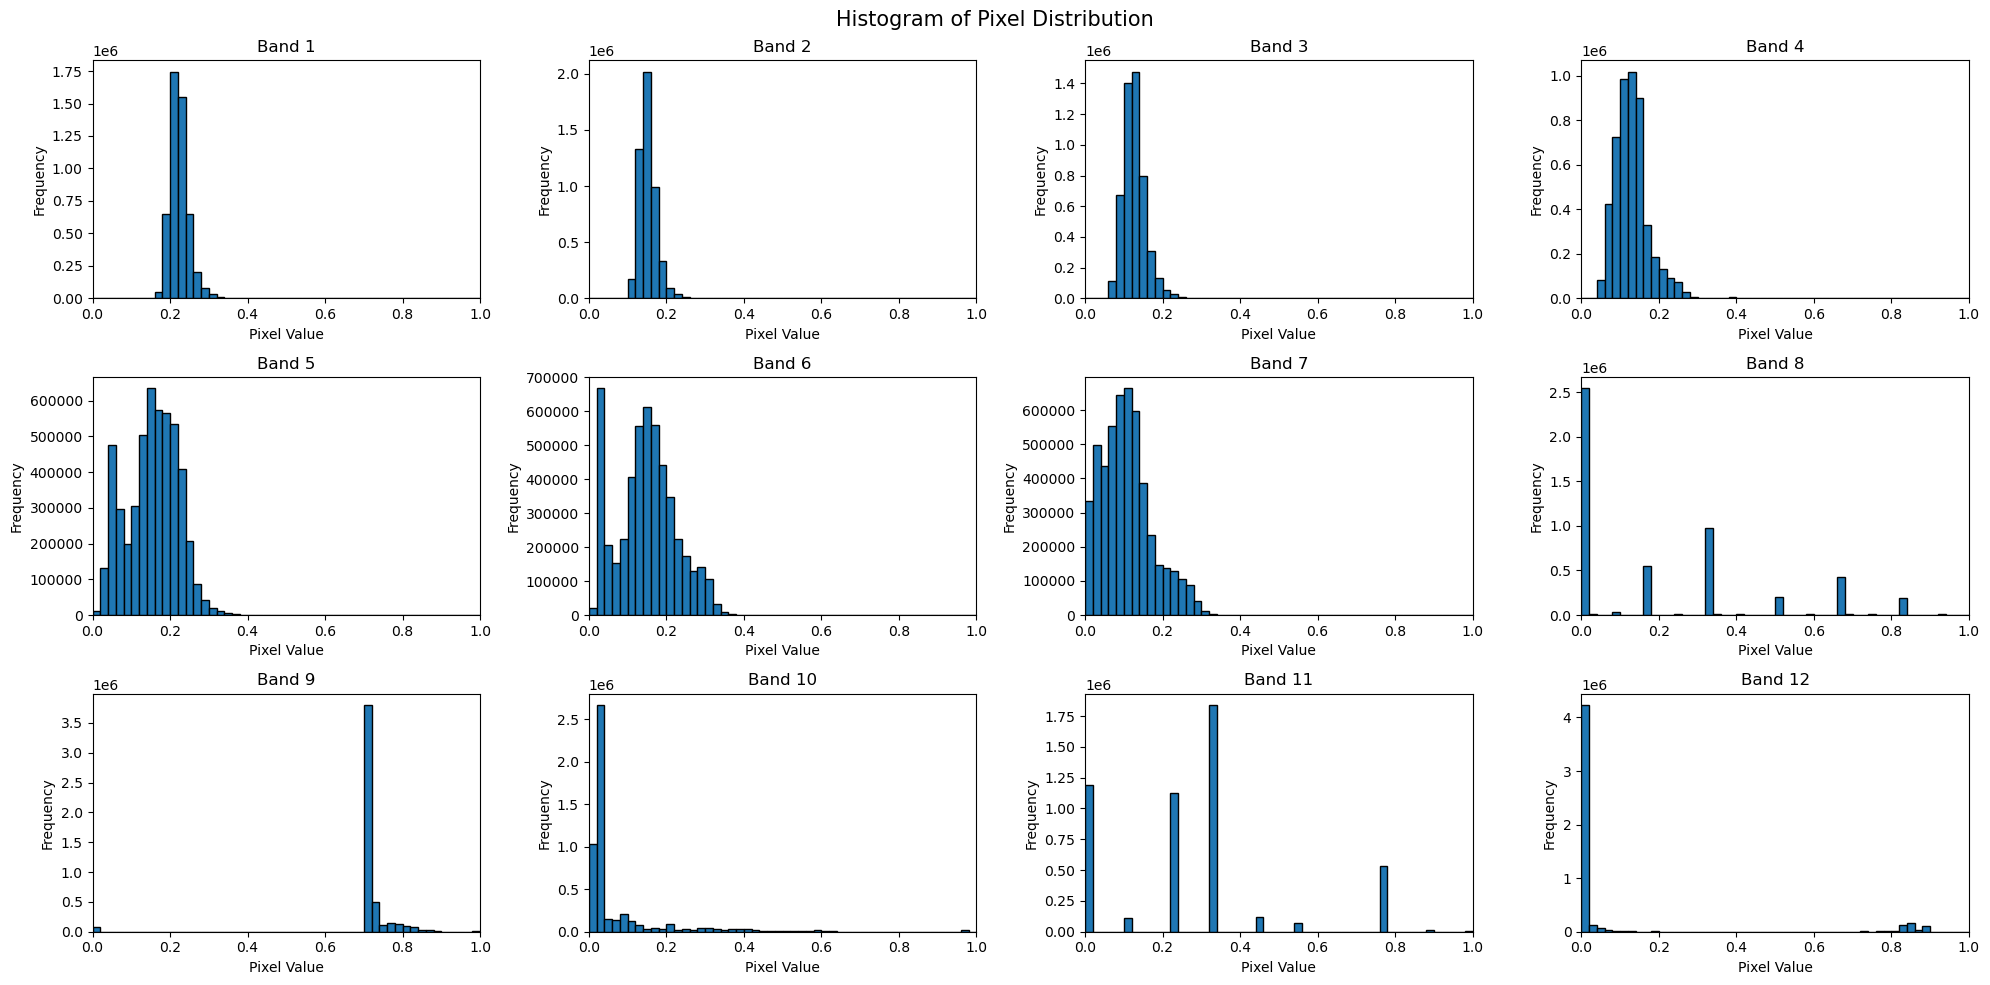

In [9]:
plot_band_histograms(images)


## visualize the bands of first 5 images

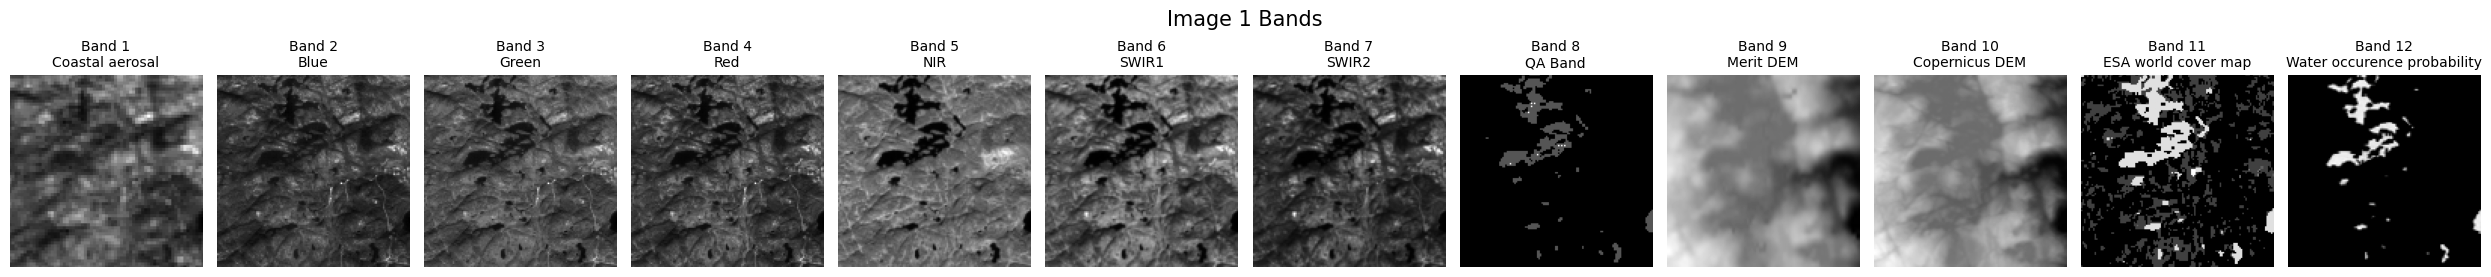

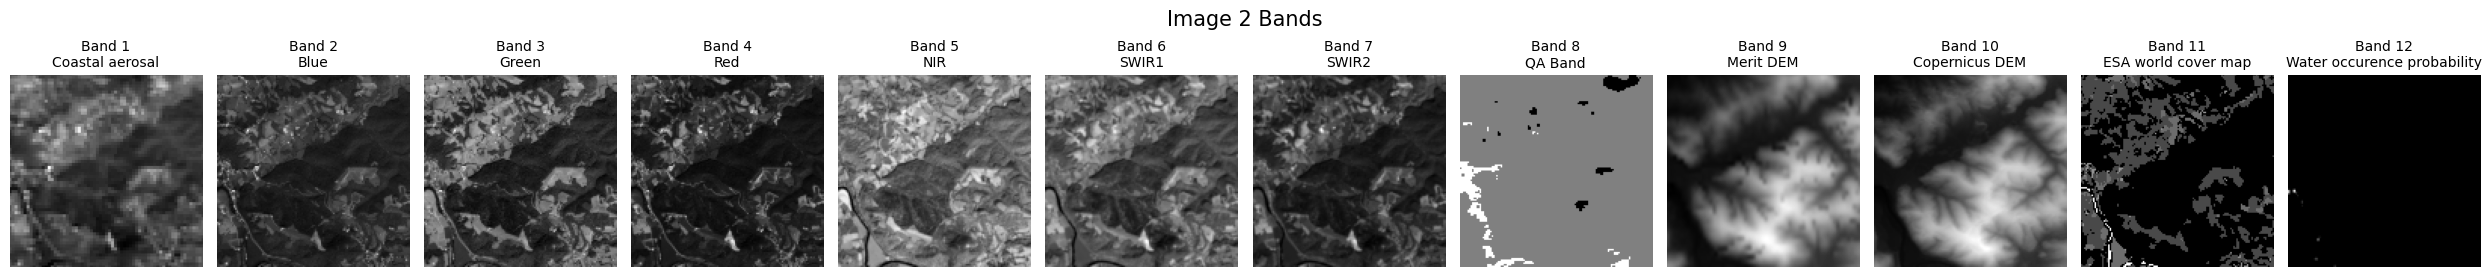

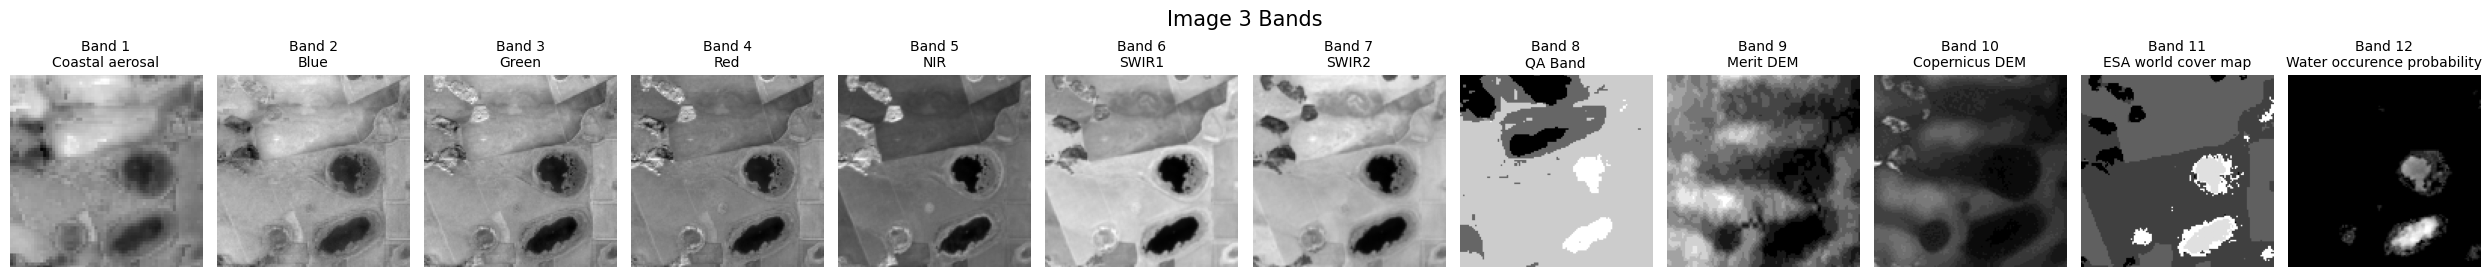

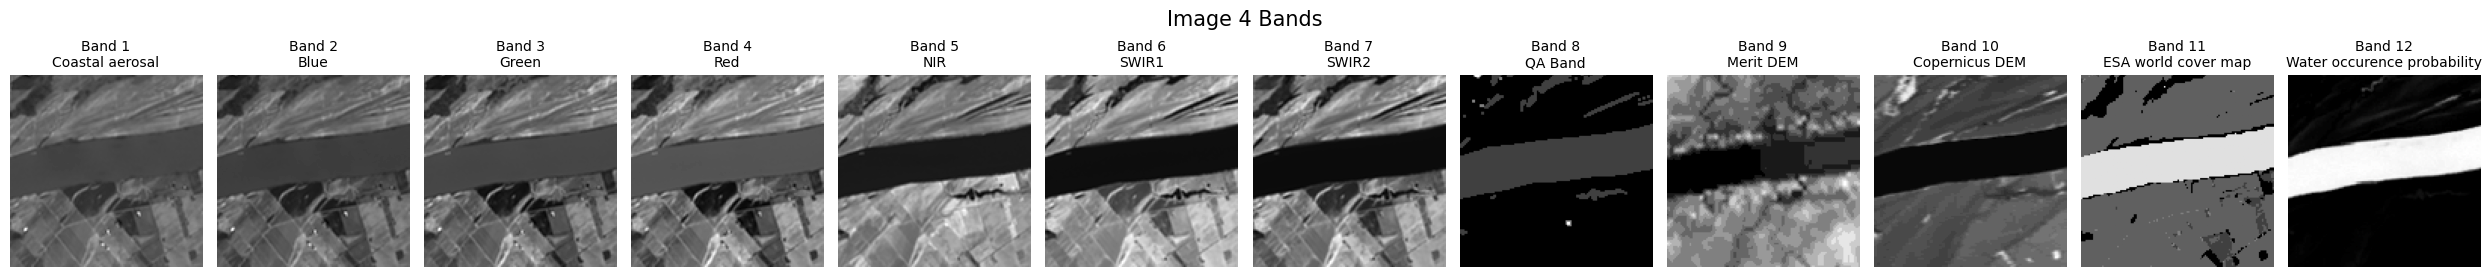

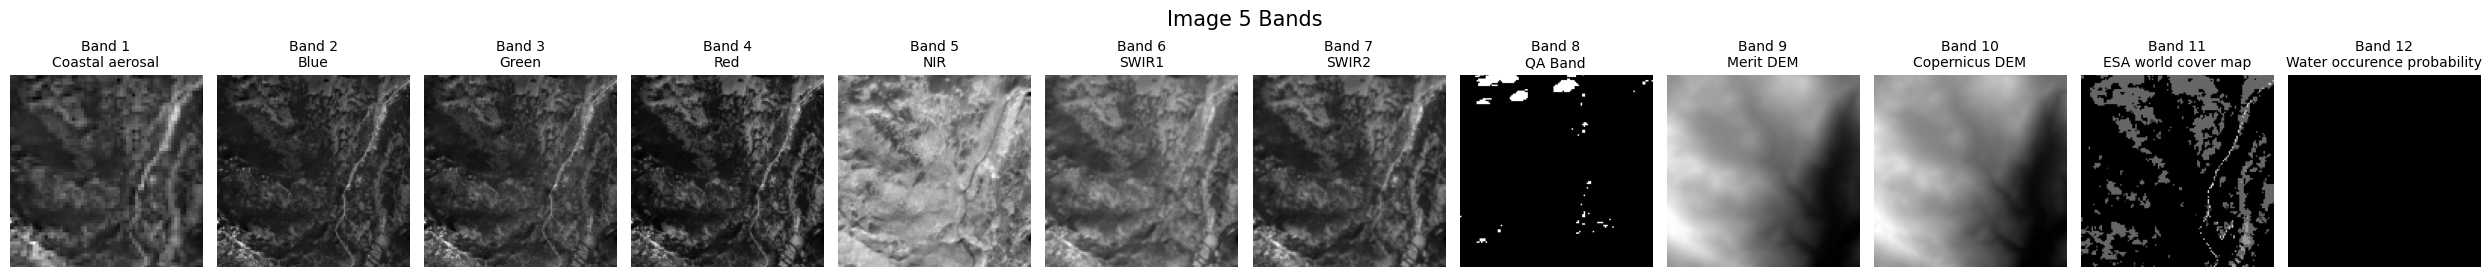

In [10]:
for i in range(5):
    visualize_image_bands(images[i], f'Image {i + 1} Bands')

> split data into 80% for training and 20% for testing

In [11]:
train_size = int(0.8 * len(images))

x_train, x_test = images[:train_size], images[train_size:]
y_train, y_test = masks[:train_size], masks[train_size:]

In [12]:
print (f'x_train shape: {np.array(x_train).shape}\nx_test shape: {np.array(x_test).shape}')

x_train shape: (244, 128, 128, 12)
x_test shape: (62, 128, 128, 12)


# Model Architecture

## Build Functions

In [13]:
def train(model):
    model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy',
                          BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou'),
                          Precision(name='precision'),
                          Recall(name='recall')])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        np.array(x_train), np.array(y_train),
        validation_data=(np.array(x_test), np.array(y_test)),
        epochs=100, batch_size=32, callbacks=[early_stop])

    return history

In [14]:
def model_evaluation(model):
    train_loss, train_acc, train_iou, train_prec, train_rec = model.evaluate(np.array(x_train), np.array(y_train))
    test_loss, test_acc, test_iou, test_prec, test_rec = model.evaluate(np.array(x_test), np.array(y_test))
    
    def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall + 1e-5)
    
    train_f1 = f1_score(train_prec, train_rec)
    test_f1 = f1_score(test_prec, test_rec)

    print('== Training ==\n' +\
      f'Accuracy: {train_acc:.4f}, IoU: {train_iou:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1_Score: {train_f1:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc:.4f}, IoU: {test_iou:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1_Score: {test_f1:.4f}'
     )

In [15]:
def Loss_Acc_Evol(history):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='m')
    plt.legend()
    plt.title('Loss Evolution')
    
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [16]:
def plot_conf_matrix(model):
    y_true = np.array(y_test).flatten()
    y_pred = (model.predict(np.array(x_test)) >= 0.5).astype(int).flatten()

    cm = tf.math.confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Background', 'Water'], yticklabels=['Background', 'Water'])
    
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [17]:
def plot_pred_masks(model):
    indices = random.sample(range(len(x_test)), 5)
    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
                            
    for i, idx in enumerate(indices):
        input_img = x_test[idx]
        true_mask = y_test[idx]
        pred = model.predict(np.expand_dims(input_img, axis=0))[0, :, :, 0]
    
        # Input image
        axes[i, 0].imshow(input_img[:, :, 0], cmap='gray')
        axes[i, 0].set_title('Input Image (Band 0)')
        axes[i, 0].axis('off')
    
        # True mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
    
        # Predicted mask
        axes[i, 2].imshow(pred >= 0.5, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Custom UNet

In [26]:
def UNet_from_Scratch():
    # Input Layer
    inputs = Input((128, 128, 12))

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [27]:
model_scratch = UNet_from_Scratch()

history_scratch = train(model_scratch)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.6647 - iou: 0.0352 - loss: 1.4308 - precision: 0.1246 - recall: 0.0557 - val_accuracy: 0.8245 - val_iou: 0.2583 - val_loss: 0.7483 - val_precision: 0.9974 - val_recall: 0.2585
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8164 - iou: 0.3288 - loss: 0.7245 - precision: 0.9974 - recall: 0.3291 - val_accuracy: 0.8465 - val_iou: 0.3519 - val_loss: 0.5708 - val_precision: 0.9964 - val_recall: 0.3524
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.8296 - iou: 0.3547 - loss: 0.5264 - precision: 0.9758 - recall: 0.3585 - val_accuracy: 0.7023 - val_iou: 0.4193 - val_loss: 0.7247 - val_precision: 0.4377 - val_recall: 0.9091
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7726 - iou: 0.4232 - loss: 0.5732 - precision: 0.6048 - recall: 0.6277 - val_accuracy: 0.8955 - val_iou: 0.5915 - val_loss: 0.3667 - val_precision: 0.8865 - val_recall: 0.6399
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/

In [28]:
model_evaluation(model_scratch)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9782 - iou: 0.9209 - loss: 0.0576 - precision: 0.9565 - recall: 0.9611
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9523 - iou: 0.8148 - loss: 0.1506 - precision: 0.9043 - recall: 0.8916
== Training ==
Accuracy: 0.9783, IoU: 0.9215, Precision: 0.9586, Recall: 0.9597, F1_Score: 0.9591

== Testing ==
Accuracy: 0.9553, IoU: 0.8262, Precision: 0.9115, Recall: 0.8983, F1_Score: 0.9048


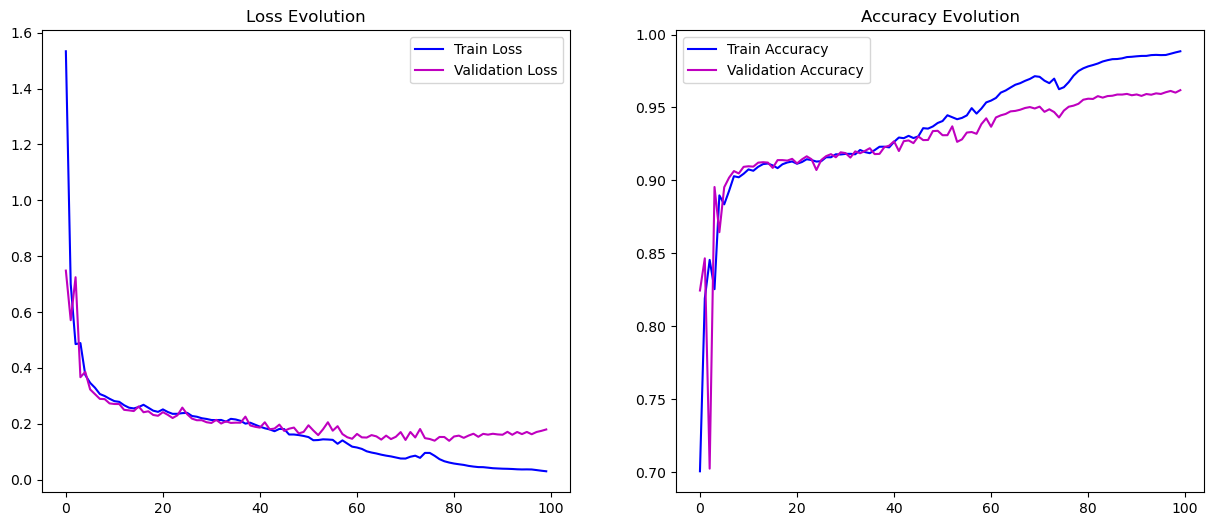

In [29]:
Loss_Acc_Evol(history_scratch)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


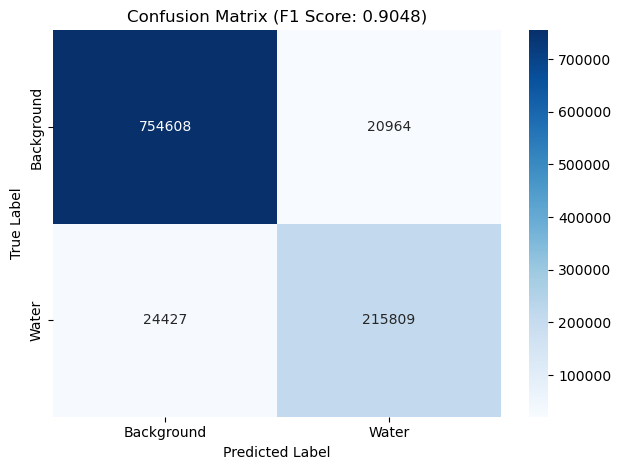

In [30]:
plot_conf_matrix(model_scratch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


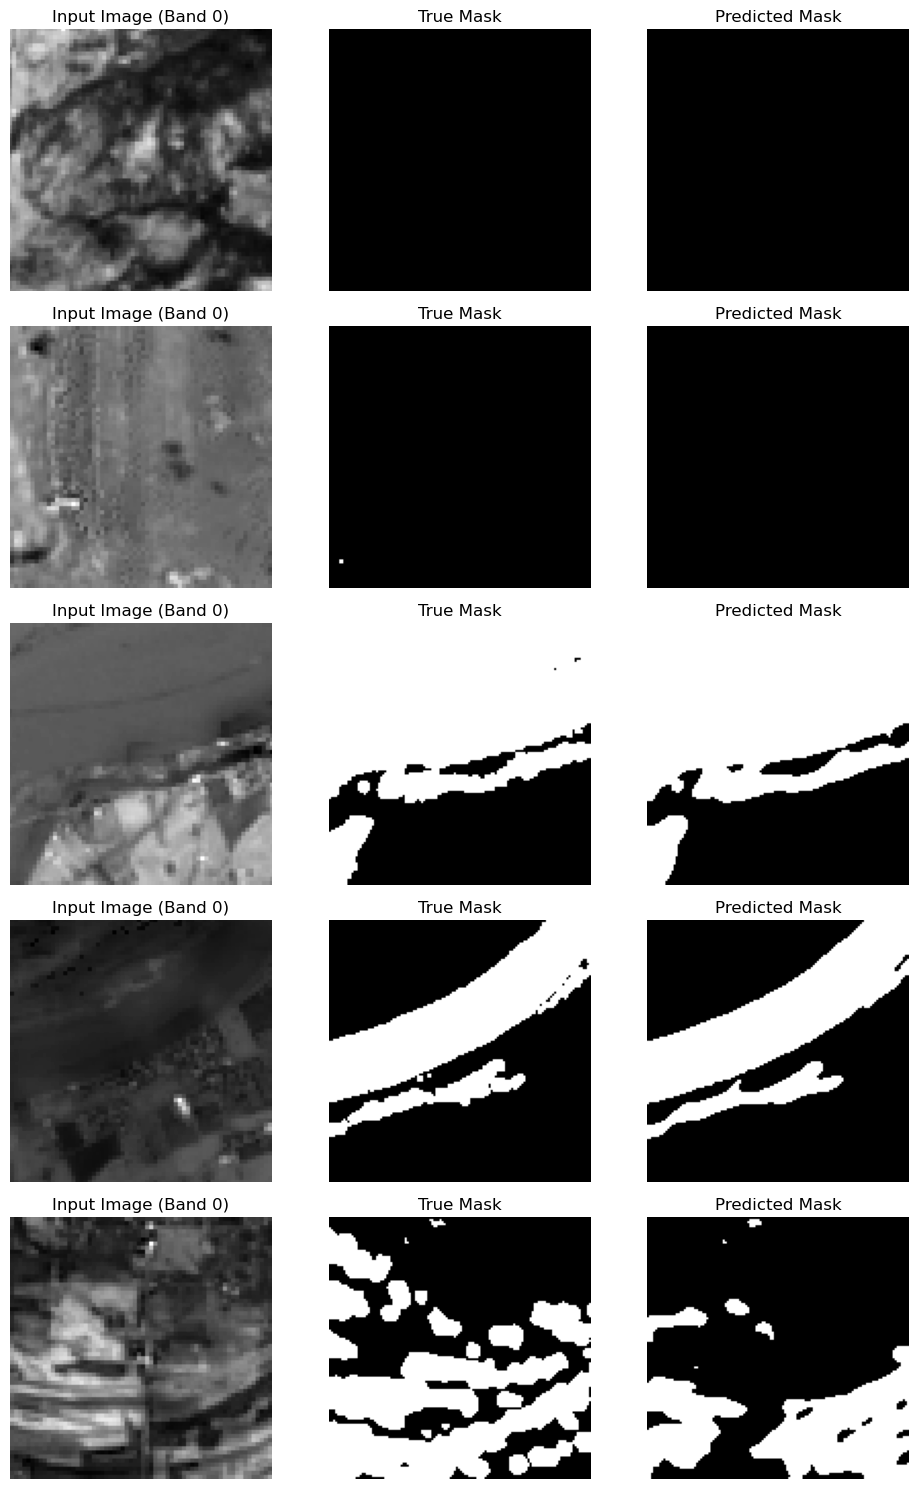

In [34]:
plot_pred_masks(model_scratch)

In [32]:
model_scratch.save('../Model/UNet_custom_model.keras')

In [33]:
model_scratch.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_16[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_18[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_20[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ dropout_5[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 16, 16,    │          0 │ conv2d_21[0][0] 

 Total params: 94,152,389 (359.16 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,768,260 (239.44 MB)

## EfficientNetV2B0

In [18]:
def unet_pretrained_EfficientNetV2B0():
    inputs = Input((128, 128, 12))

    # Reduce channels 12 -> 3 
    x = Conv2D(3, (1, 1), activation='relu', padding='same')(inputs)

    # Encoder
    backbone = EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    backbone.trainable = True 

    encoder_output = backbone(x, training=False)  

    # Decoder
    u1 = UpSampling2D((2, 2))(encoder_output)
    c1 = Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u1)
    c1 = Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c1)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.3)(c1)  

    u2 = UpSampling2D((2, 2))(c1)
    c2 = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u2)
    c2 = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c2)
    c2 = Dropout(0.3)(c2)

    u3 = UpSampling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(u3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(c3)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)

    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.2)(c4)

    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = Dropout(0.2)(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)  # Final output: (128, 128, 1)

    model = Model(inputs, outputs)
    return model

In [19]:
model_efficientb0 = unet_pretrained_EfficientNetV2B0()

history_model_efficientb0 = train(model_efficientb0)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.7056 - iou: 0.0548 - loss: 4.4527 - precision: 0.2910 - recall: 0.0678 - val_accuracy: 0.7635 - val_iou: 0.0000e+00 - val_loss: 4.1419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.7767 - iou: 0.2820 - loss: 3.7517 - precision: 0.5739 - recall: 0.3556 - val_accuracy: 0.7575 - val_iou: 0.0253 - val_loss: 4.9593 - val_precision: 0.3377 - val_recall: 0.0266
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8283 - iou: 0.4735 - loss: 3.0840 - precision: 0.7476 - recall: 0.5643 - val_accuracy: 0.4813 - val_iou: 0.2073 - val_loss: 3.9755 - val_precision: 0.2451 - val_recall: 0.5736
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8339 - iou: 0.5319 - loss: 2.5005 - precision: 0.7569 - recall: 0.6429 - val_accuracy: 0.4012 - val_iou: 0.2173 - val_loss: 2.5178 - val_precision: 0.2393 -

In [20]:
model_evaluation(model_efficientb0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 822ms/step - accuracy: 0.9293 - iou: 0.7560 - loss: 0.3135 - precision: 0.8955 - recall: 0.8290
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 874ms/step - accuracy: 0.9030 - iou: 0.6551 - loss: 0.3546 - precision: 0.8014 - recall: 0.7820
== Training ==
Accuracy: 0.9311, IoU: 0.7622, Precision: 0.9019, Recall: 0.8310, F1_Score: 0.8650

== Testing ==
Accuracy: 0.9019, IoU: 0.6522, Precision: 0.8013, Recall: 0.7781, F1_Score: 0.7895


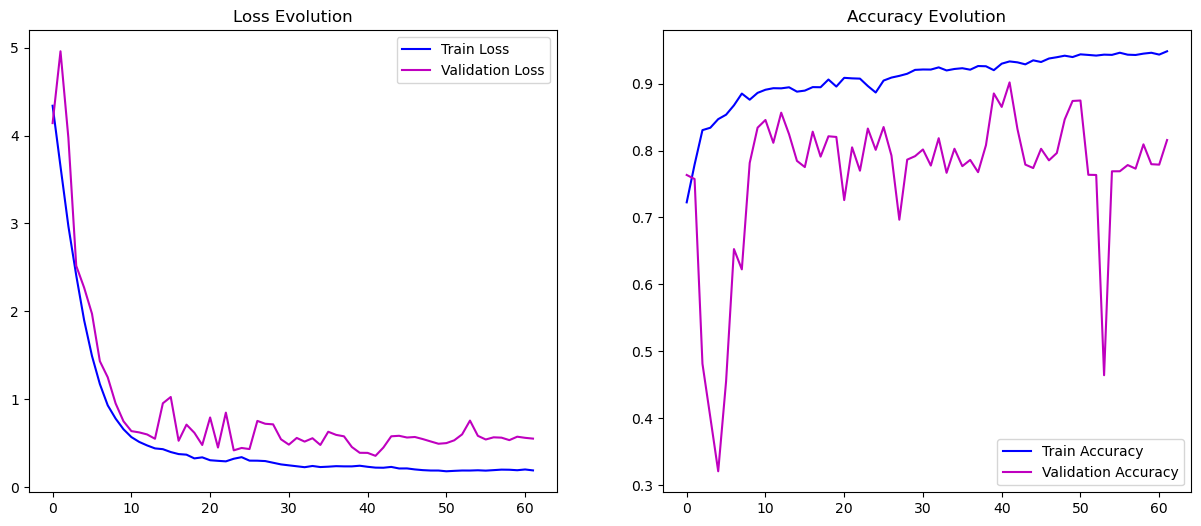

In [21]:
Loss_Acc_Evol(history_model_efficientb0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


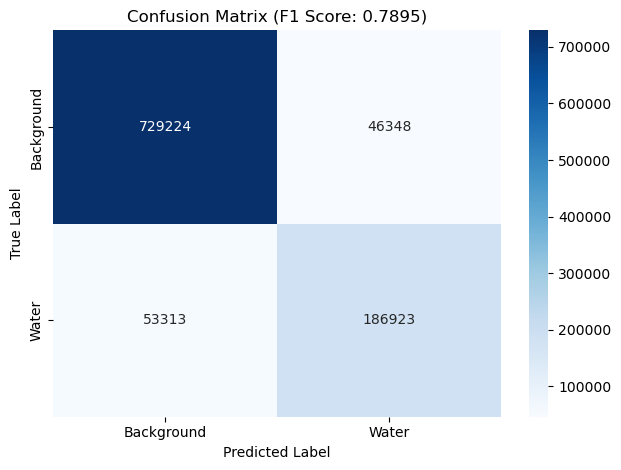

In [22]:
plot_conf_matrix(model_efficientb0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


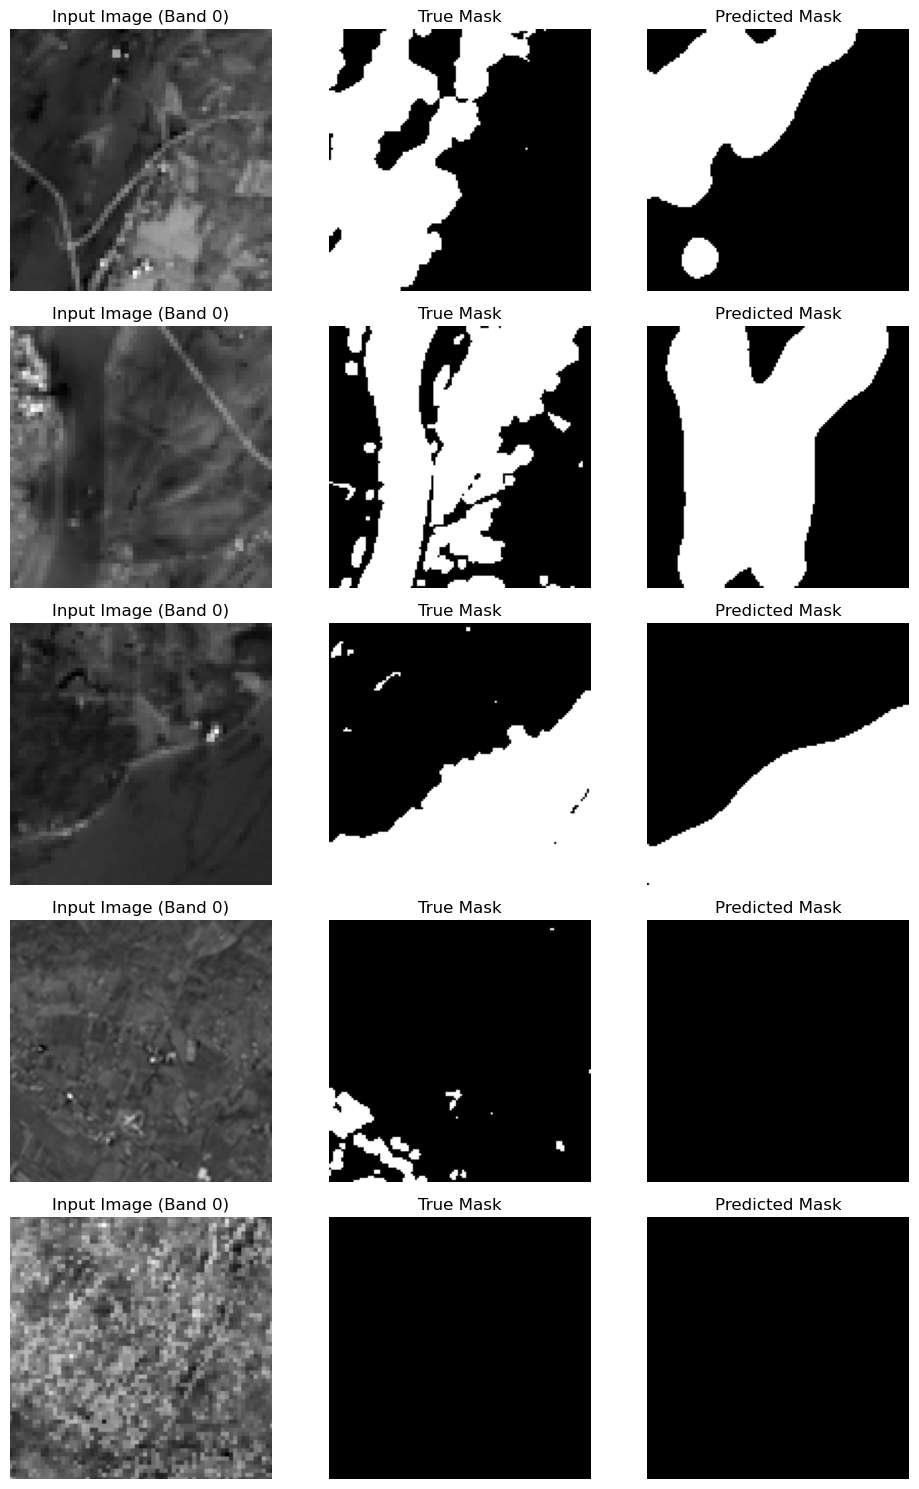

In [23]:
plot_pred_masks(model_efficientb0)

In [24]:
model_efficientb0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 1024)     │    11,797,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,92

 Total params: 109,561,130 (417.94 MB)

 Trainable params: 36,499,320 (139.23 MB)

 Non-trainable params: 63,168 (246.75 KB)

 Optimizer params: 72,998,642 (278.47 MB)

In [25]:
model_efficientb0.save('../Model/UNet_EfficientV2B0.keras')

## ResNet34

In [35]:
BACKBONE = 'resnet34'

unet_resnet34 = Unet(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid', 
    encoder_weights=None  
)

In [36]:
history_unet_resnet34 = train(unet_resnet34)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7680 - iou: 0.3732 - loss: 0.5371 - precision: 0.5898 - recall: 0.4865 - val_accuracy: 0.7519 - val_iou: 0.0190 - val_loss: 3.9870 - val_precision: 0.2266 - val_recall: 0.0204
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8908 - iou: 0.6315 - loss: 0.3374 - precision: 0.8539 - recall: 0.7080 - val_accuracy: 0.7530 - val_iou: 0.0174 - val_loss: 3.9733 - val_precision: 0.2276 - val_recall: 0.0185
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9007 - iou: 0.6731 - loss: 0.2924 - precision: 0.8749 - recall: 0.7450 - val_accuracy: 0.7581 - val_iou: 0.0100 - val_loss: 3.8956 - val_precision: 0.2374 - val_recall: 0.0103
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9099 - iou: 0.6907 - loss: 0.2627 - precision: 0.8914 - recall: 0.7540 - val_accuracy: 0.7516 - val_iou: 0.0205 - val_loss: 3.9038 - val_precision: 0.2326 - val_recall: 0.0219
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

In [37]:
model_evaluation(unet_resnet34)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.9870 - iou: 0.9515 - loss: 0.0328 - precision: 0.9831 - recall: 0.9672
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.9556 - iou: 0.8235 - loss: 0.1488 - precision: 0.9274 - recall: 0.8801
== Training ==
Accuracy: 0.9871, IoU: 0.9521, Precision: 0.9838, Recall: 0.9673, F1_Score: 0.9755

== Testing ==
Accuracy: 0.9588, IoU: 0.8361, Precision: 0.9333, Recall: 0.8893, F1_Score: 0.9107


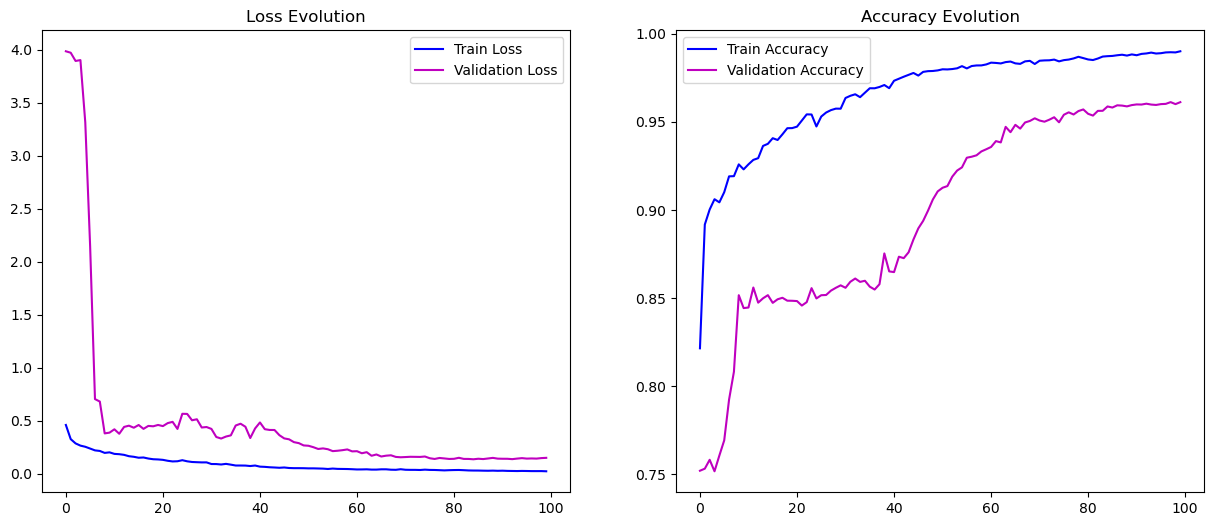

In [38]:
Loss_Acc_Evol(history_unet_resnet34)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


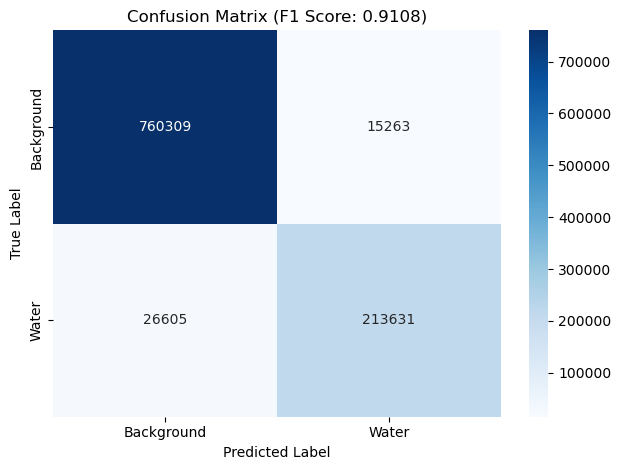

In [39]:
plot_conf_matrix(unet_resnet34)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


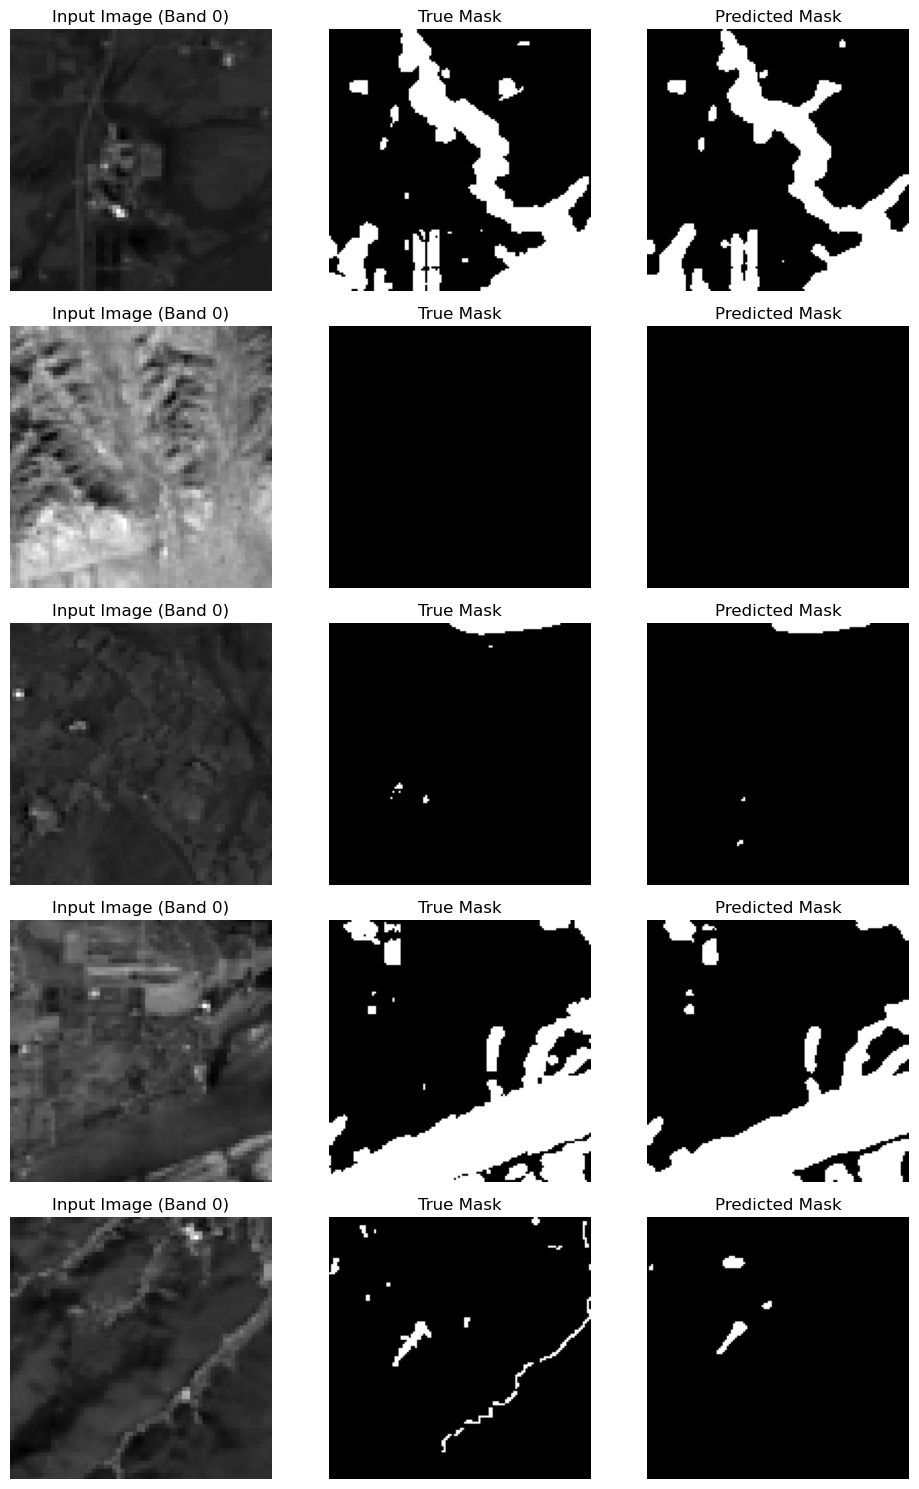

In [40]:
plot_pred_masks(unet_resnet34)

In [41]:
unet_resnet34.save('../Model/UNet_ResNet34_model.keras')

In [42]:
unet_resnet34.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 73,418,481 (280.07 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

 Optimizer params: 48,934,076 (186.67 MB)

## ResNet50

In [43]:
BACKBONE = 'resnet50'

unet_resnet50 = Unet(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

In [44]:
history_resnet50 = train(unet_resnet50)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6976 - iou: 0.3356 - loss: 0.5788 - precision: 0.4165 - recall: 0.6223 - val_accuracy: 0.7579 - val_iou: 0.0106 - val_loss: 3.8846 - val_precision: 0.2404 - val_recall: 0.0110
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8839 - iou: 0.6290 - loss: 0.3838 - precision: 0.7857 - recall: 0.7600 - val_accuracy: 0.7596 - val_iou: 0.0085 - val_loss: 3.8708 - val_precision: 0.2565 - val_recall: 0.0087
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8923 - iou: 0.6316 - loss: 0.3347 - precision: 0.8183 - recall: 0.7355 - val_accuracy: 0.6773 - val_iou: 0.0999 - val_loss: 3.7530 - val_precision: 0.2269 - val_recall: 0.1515
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8990 - iou: 0.6788 - loss: 0.2938 - precision: 0.8808 - recall: 0.7482 - val_accuracy: 0.7615 - val_iou: 0.0273 - val_loss: 2.9293 - val_precision: 0.4345 - val_recall: 0.0283
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/

In [45]:
model_evaluation(unet_resnet50)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.8374 - iou: 0.3931 - loss: 0.4213 - precision: 0.9645 - recall: 0.3989
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.8560 - iou: 0.4022 - loss: 0.3846 - precision: 0.9470 - recall: 0.4114
== Training ==
Accuracy: 0.8405, IoU: 0.4085, Precision: 0.9644, Recall: 0.4147, F1_Score: 0.5800

== Testing ==
Accuracy: 0.8573, IoU: 0.4090, Precision: 0.9523, Recall: 0.4175, F1_Score: 0.5805


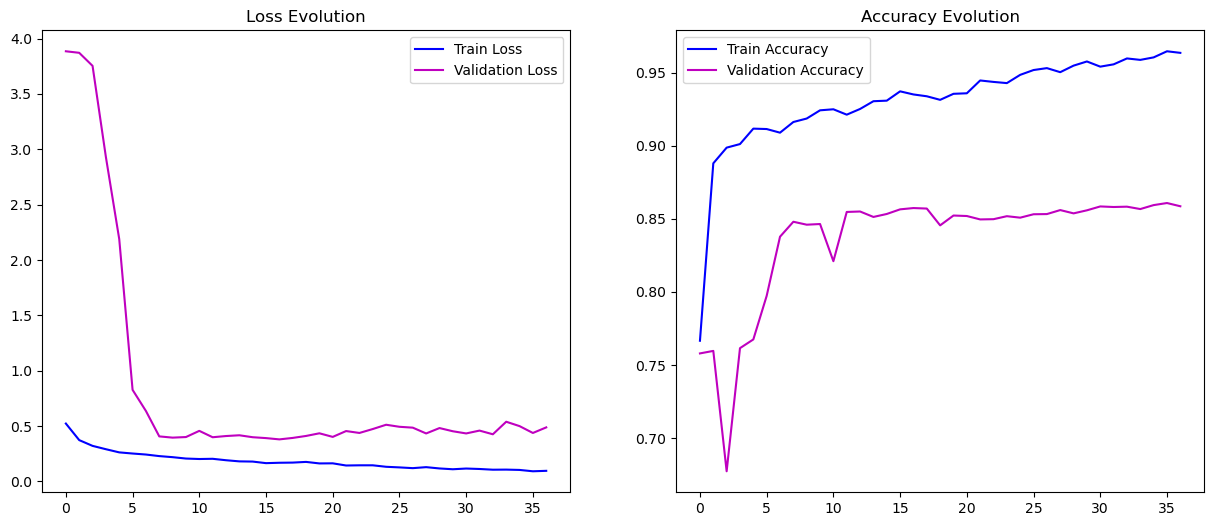

In [46]:
Loss_Acc_Evol(history_resnet50)

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AF3ADB5F80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


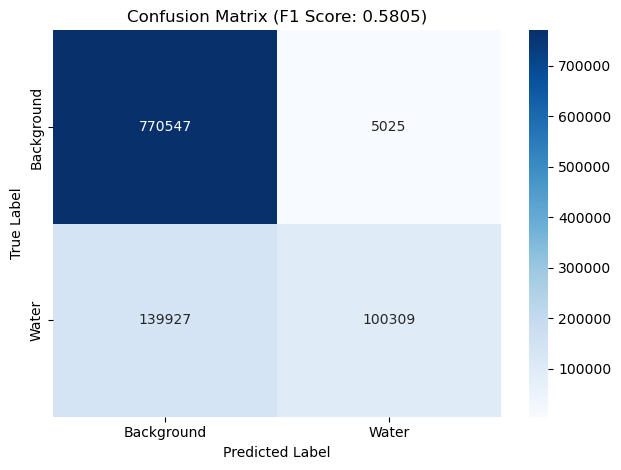

In [47]:
plot_conf_matrix(unet_resnet50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


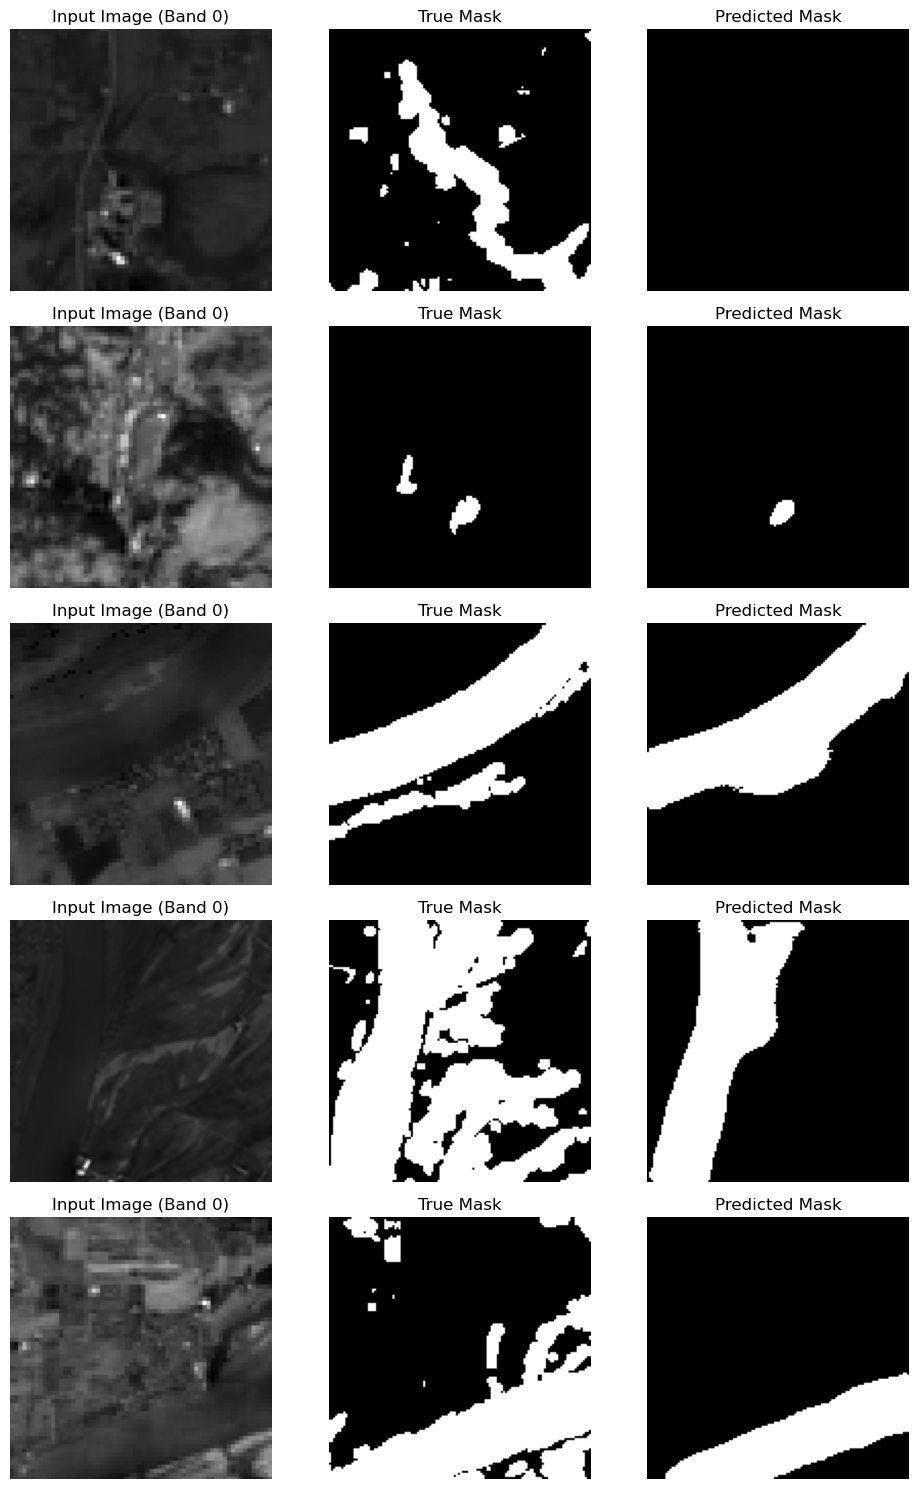

In [48]:
plot_pred_masks(unet_resnet50)

In [49]:
unet_resnet50.save('../Model/UNet_ResNet50_model.keras')

In [50]:
unet_resnet50.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_34   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d_3… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 32, 32,    │          0 │ stage1_unit1_bn3

 Total params: 97,672,945 (372.59 MB)

 Trainable params: 32,541,789 (124.14 MB)

 Non-trainable params: 47,576 (185.84 KB)

 Optimizer params: 65,083,580 (248.27 MB)

# Model Dataframe

In [57]:
model_names = ['Custom UNet', 'EfficientNetV2B0', 'ResNet34', 'ResNet50']
models = [model_scratch, model_efficientb0, unet_resnet34, unet_resnet50]

results = []

for name, model in zip(model_names, models):
    test_loss, test_acc, test_iou, test_prec, test_rec = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
    results.append({'Model Name': name, 'Accuracy': test_acc, 'IoU': test_iou})

df = pd.DataFrame(results)
df

Model Name  Accuracy       IoU
0       Custom UNet  0.955315  0.826221
1  EfficientNetV2B0  0.901890  0.652245
2          ResNet34  0.958784  0.836132
3          ResNet50  0.857304  0.408989

In [58]:
best_model = df.loc[df['IoU'].idxmax()]
print(f'Best Model Based on IoU: {best_model['Model Name']}')

Best Model Based on IoU: ResNet34


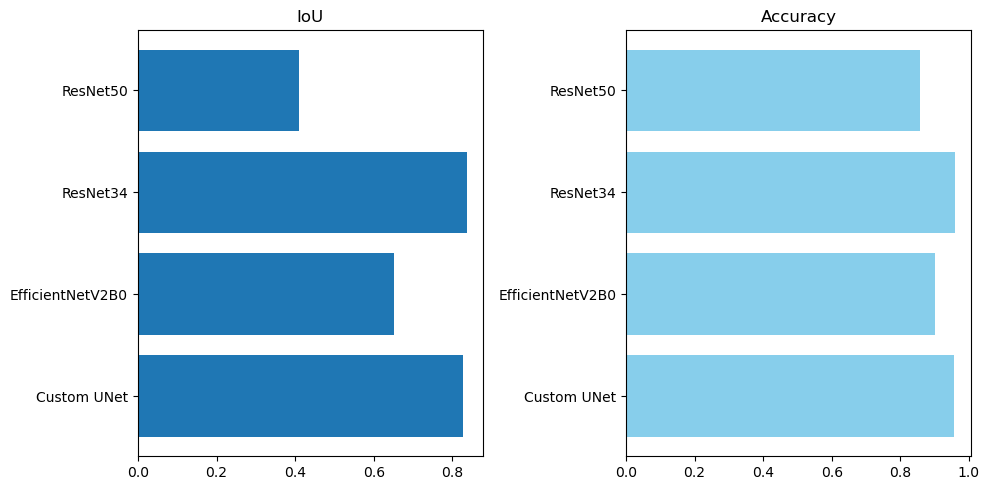

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.barh(df['Model Name'], df['IoU'])
ax1.set_title('IoU')

ax2.barh(df['Model Name'], df['Accuracy'], color='skyblue')
ax2.set_title('Accuracy')

plt.tight_layout()
plt.show()

# Conclusion
- A Various amount of models was trained and tested for the satellite water segmentaion task. The shown models gave the highest accuracies and can say the same for the IoU. We can observe that the best models according to both accuracies and IoU were the Custom Model and ResNet34 Segmentation model, with both accuracy and IoU being slightly higher for the ResNet34; So it would be the chosen model for deployment.

- Kindly note that the EfficientNetV2B0 wasn't entirely pretrained as the decoder part was manually implemneted, also tried adding skip connections but failed so went forward to trying completely pretrained models from segmentation model package.